# 0. Initial setup, packages installation, and loading the necessary libraries.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
# PATH = '/content/drive/My Drive/Courses/FourthBrain/Week 8/Midterm Project/Option 1/'
PATH = ''
# os.chdir(PATH)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from google.colab.patches import cv2_imshow
%matplotlib inline

from utils import *

In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING']="1"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import models, transforms
import time
import copy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Building a Model to Classify Retinal Disease

 > ## 1.1 Exploratory Data Analysis

In [4]:
train_df = load_data(PATH+'data/train/train.csv', ',')
print(train_df.shape)

# Let's visualize some rows of the data. The first columns corresponds to the
# image file and the rest if the image contain any of the retinal disease.
train_df.head(100)

FILE EXIST
(3435, 8)


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
95,8518b692368f.jpg,1,1,0,1,0,0,0
96,7a3e5d2d09bc.jpg,1,1,0,1,0,0,0
97,b58ca12cea1b.jpg,1,0,0,0,0,0,0
98,698d188ddd7d.jpg,1,0,0,0,0,0,0


Let's visualize now some of the images corresponding to each retinal disease. This will help us to understand a bit better the problem at hand.

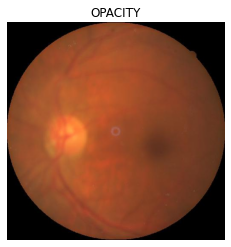

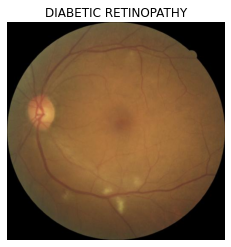

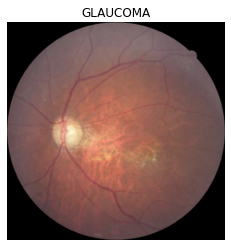

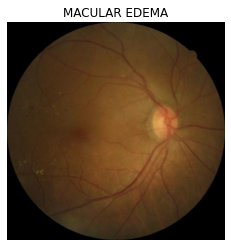

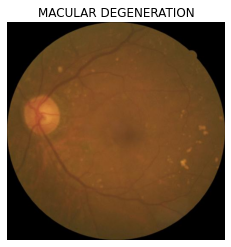

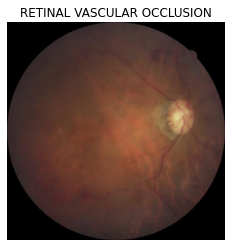

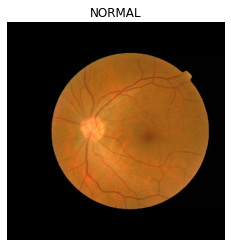

In [7]:
# Examples of retinal images correspinding to each category.
disease_labels = train_df.columns[1:]

for i in disease_labels:
    image_file = train_df.loc[train_df[i] == 1, 'filename'].sample().values[0]
    image = mpimg.imread(PATH+'data/train/train/'+image_file)
    
    plt.title(i.upper())
    plt.axis("off")
    plt.imshow(image)
    plt.show()

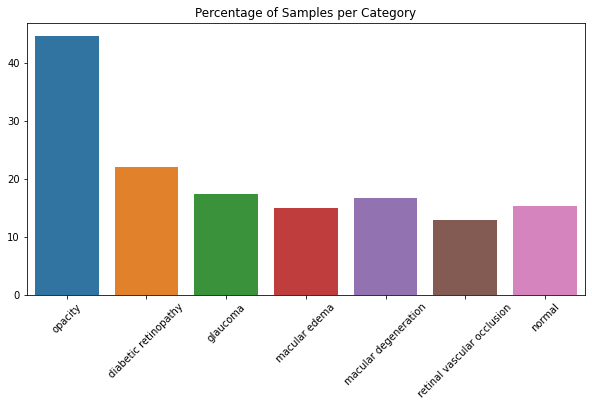

retinal vascular occlusion     440
macular edema                  516
normal                         525
macular degeneration           574
glaucoma                       597
diabetic retinopathy           755
opacity                       1533
dtype: int64


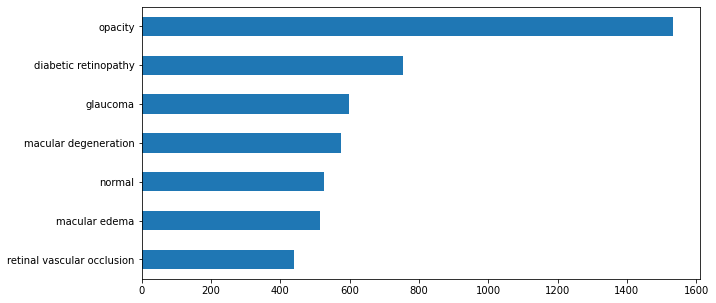

In [7]:
# Display the percentage and number of samples per disease label.
category_percentage(train_df, disease_labels)

plt.figure(figsize=(10, 5))
train_df[disease_labels].sum().sort_values().plot(kind='barh')
print(train_df[disease_labels].sum().sort_values())
plt.show()

After inspecting the previous graph it is evident that our data is imbalanced. There are for example 1000 (approx.) cases more of the label "*opacity*" compared to most of the other labels. 

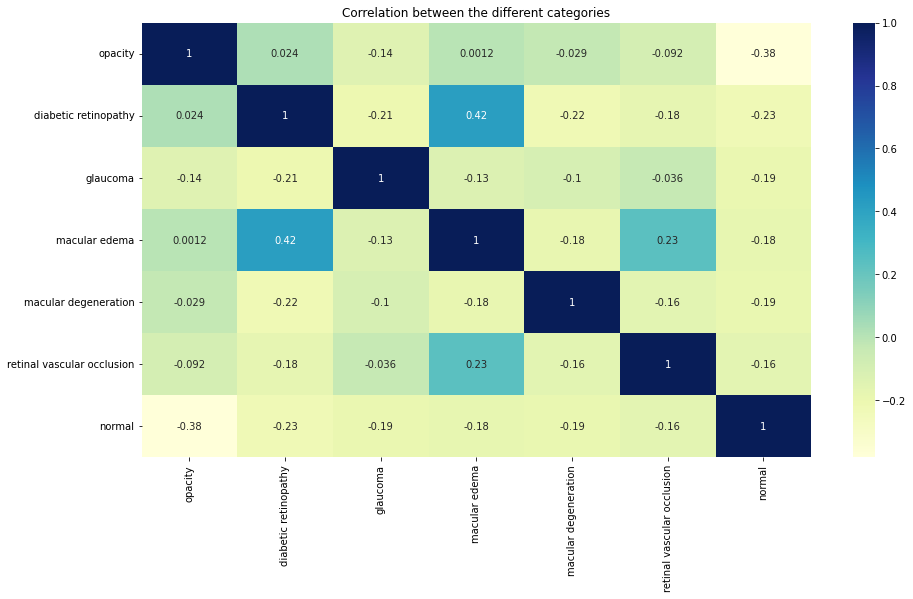

In [8]:
# Correlation between disease.
correlation_between_labels(train_df)

According to the correlation matrix, it seems there is no significant correlation between the different retinal disorders that are present in this dataset.

There is just a minor correlation  (`0.42`) between '*diabetic retinopathy*' and '*macular edema*', and (`0.23`) between '*macular edema*' and '*retinal vascular occlusion*'. Therefore, it shouln't be surprising that after training a model with this data, and when making predictions to an image with either '*diabetic retinopathy*' or '*macular edema*', then the image could get both labels.

A correlation is considered significant for values above `0.5` with a `p-value<0.05`.

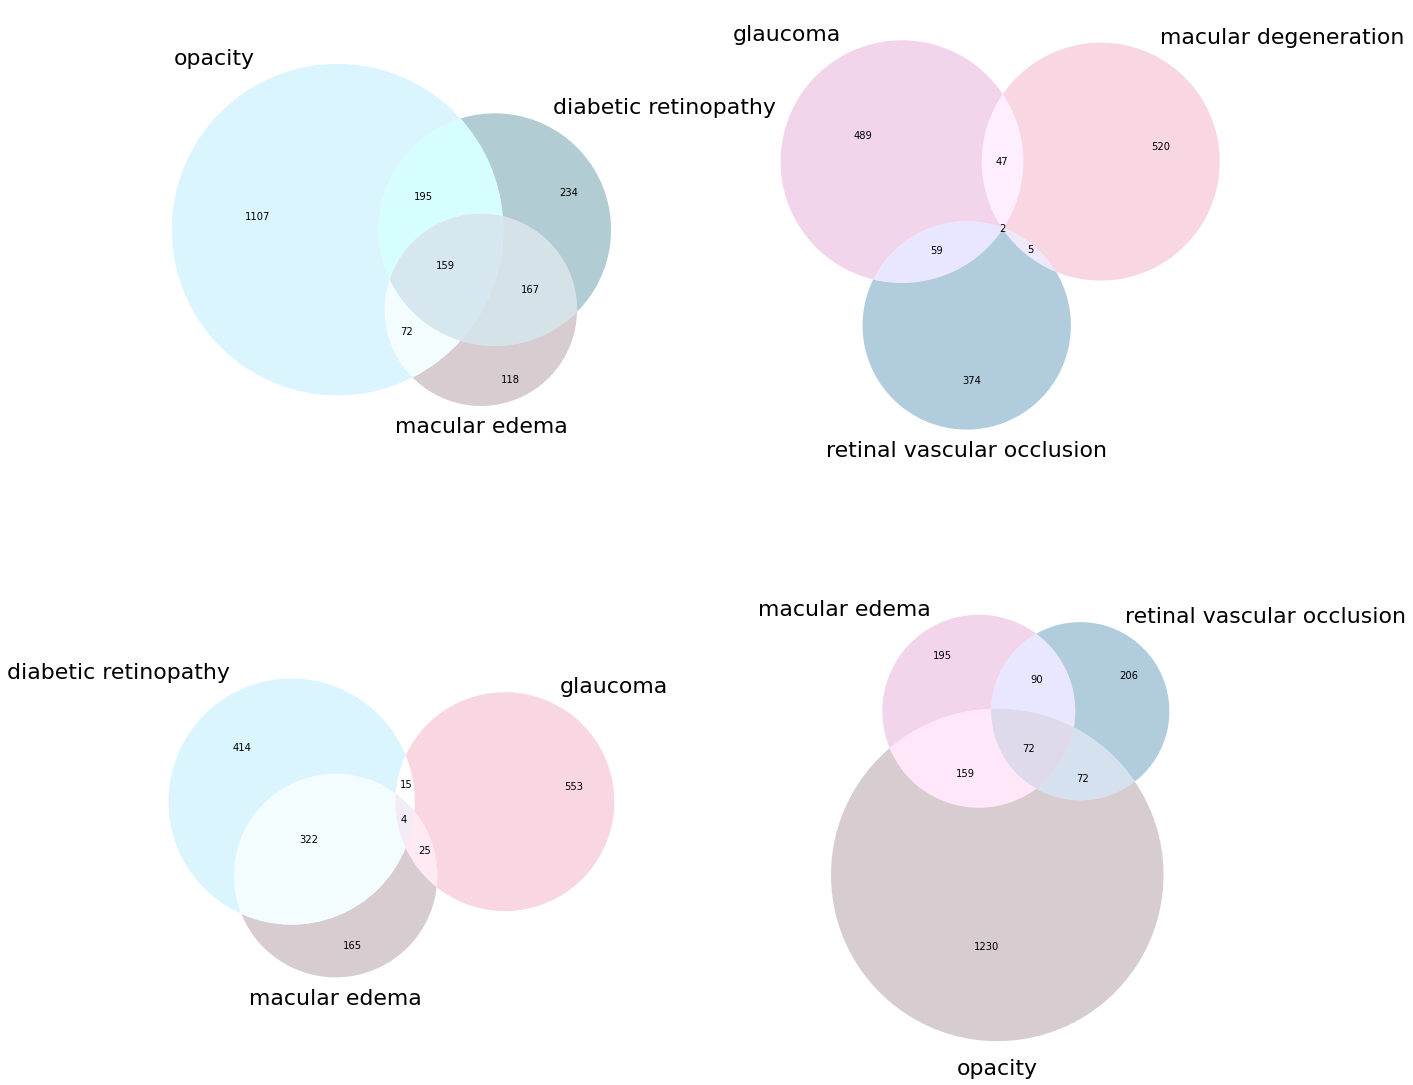

In [9]:
# Now let's explore the interrelation between categories.
venn_diagram(train_df, disease_labels, [0, 1, 3], [2, 4, 5], [1, 2, 3], [3, 5, 0])

As expected there is an overlap between the "macular edema" and the "diabetic retinopathy" disorder, and also some intersection of these two with '"opacity".

There is not much overlap between "glaucoma", "macular degeneration" and "retinal vascular occlusion".

There is also some overlap between "macular edema" and "retinal vascular oclusion".


 > ## 1.1.1 Filtering the clases in the dataset.

Filter the dataset to leave only the clases: "*diabetic retinopathy*", "*glaucoma*", and all the rest of disorders as "*other*". Category "*normal*" is kept.

In [8]:
train_dfv2 = train_df
train_dfv2['other'] = np.where(
        (train_dfv2['retinal vascular occlusion'] == 1) |
        (train_dfv2['macular edema'] == 1) |
        (train_dfv2['macular degeneration'] == 1) |
        (train_dfv2['opacity'] == 1), 1, 0)

train_dfv2 = train_df[['filename', 'diabetic retinopathy', 'glaucoma', 'other', 'normal']]

train_dfv2.head()

,filename,diabetic retinopathy,glaucoma,other,normal
0,c24a1b14d253.jpg,0,0,1,0
1,9ee905a41651.jpg,0,0,1,0
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,1,0
4,0def470360e4.jpg,0,0,1,0


 > ## 1.2 Setting up of a data augmentation pipeline.

In the following cell I create a the dataset class containing a set of standard image transformations:


*   `transforms.Resize(224)`: for adjusting the image size to the networks' input
*   `transforms.RandomHorizontalFlip(p=1.0)`: flip the image on the horizontal edge
*   `transforms.RandomVerticalFlip(p=1.0)`: flip the image on the vertical edge
*   `transforms.Normalize()`: Normalize a tensor image with mean and standard deviation. The numbers are coming from the ImageNet dataset (This is because I will be using models pretrained on the ImageNet dataset).  




In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, data_file, img_dir, transform=None):
        self.img_data = data_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_data.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_data.iloc[[idx], 1:].values
        label = torch.tensor(label, dtype=torch.float32)
        image = self.transform(image)
        return image, torch.squeeze(label)

In [11]:
# Since the dataset is not that big, I decided to incorporate more images in the 
# training set. Therefore, I will be using 80% of the data for training, 15% for validation, and 5% for test.
train_df = train_dfv2
disease_labels = train_df.columns[1:]
train_data, validation_data = train_test_split(train_df, train_size=0.80, random_state=42, shuffle=True)
# Split validation into validation and test dataset
validation_data, test_data  = train_test_split(validation_data, train_size=0.75, random_state=42, shuffle=True)
print('Dataset Sizes:')
print(f'Train: {train_data.shape[0]}\nValidation: {validation_data.shape[0]}\nTest: {test_data.shape[0]}')

# Define the transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_df = {
    'train': train_data, 'val': validation_data, 'test': test_data
}

image_dataset = {x: CustomImageDataset(data_file=data_df[x],
                                       img_dir='data/train/train/',
                                       transform=data_transforms[x])
                 for x in ['train', 'val', 'test']}

batch_size = 32
dataloaders = {x: DataLoader(image_dataset[x], batch_size=batch_size,
                             shuffle=True, num_workers=0)
                for x in ['train', 'val', 'test']}

# Get some random training images
# images, labels = next(iter(dataloaders['train']))

# print('-'*30)
# print(images)
# print(type(images))
# print('-'*30)
# print(labels)
# print(type(labels))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Dataset Sizes:
Train: 2748
Validation: 515
Test: 172
cuda:0


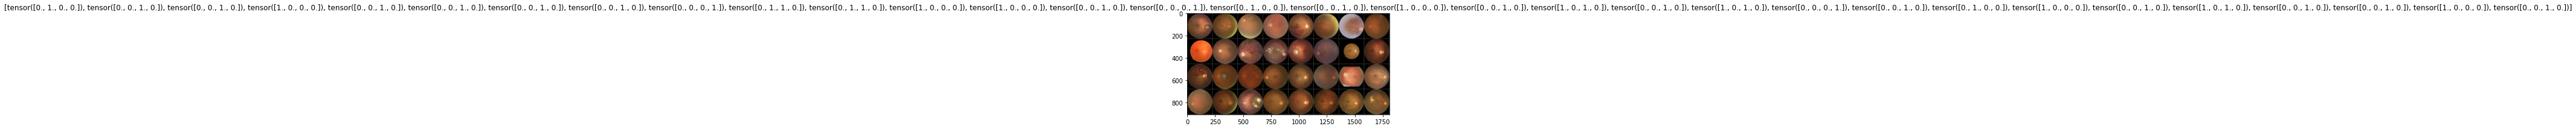

In [12]:
# Let's visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [23]:
# Training Function 
def train_model(model, criterion, optimizer, scheduler, model_name=None, weights=None, num_epochs=25):
    model_name = model_name if model_name else model.__class__.__name__
    since = time.time()
    # weights = weights.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    train_loss = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            run_Acc = 0.0
            run_Prec = 0.0
            run_Rec = 0.0
            run_F1 = 0.0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                              leave=True,
                                              total=int(len(image_dataset[phase])/dataloaders[phase].batch_size)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs)
                    preds = torch.round(preds)

                    loss = criterion(outputs, labels)
                    # loss = (loss * weights).mean()
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

                if phase == 'val':
                    y_true, y_pred = labels.data.detach().cpu(), preds.detach().cpu()

                    run_Acc += accuracy_score(y_true, y_pred)
                    run_Prec += precision_score(y_true, y_pred, average="samples", zero_division=0)
                    run_Rec += recall_score(y_true, y_pred, average="samples", zero_division=0)
                    run_F1 += f1_score(y_true, y_pred, average="samples", zero_division=0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_dataset[phase])

            if phase == 'train':
                # train_stats = '{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                #     phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc)
                train_stats = '{} ==> Loss:{:.4f}'.format(
                    phase.upper(), epoch_loss)
                train_loss.append(epoch_loss)
            else:
                Acc_sc = run_Acc / len(dataloaders[phase])
                Prec_sc = run_Prec / len(dataloaders[phase])
                Rec_sc = run_Rec / len(dataloaders[phase])
                f1_sc = run_F1 / len(dataloaders[phase])
                print(train_stats)
                print('{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                    phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc))
                validation_loss.append(epoch_loss)


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), PATH + 'models/'+model_name+'.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, validation_loss

In [24]:
def print_loss_history(train_loss, validation_loss, logscale=False):
    loss = train_loss
    val_loss = validation_loss
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

I address the imbalance characteristics of the data by calculating a weight vector corresponding to the labels, to pass it to the loss function. (See [this example](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).)

In [25]:
def get_pos_weight(df):
  train_labels_df = df
  pos_weight = []
  for c in range(train_labels_df.shape[1]):
    weight = (train_labels_df.iloc[:, c] == 0).sum() / (train_labels_df.iloc[:, c] == 1).sum()
    pos_weight.append(weight)
  return pos_weight

In [26]:
def get_weights(df):
  train_labels_df = df
  weights = []
  for c in range(train_labels_df.shape[1]):
    weight = 1 / (train_labels_df.iloc[:, c] == 1).sum()
#     weight = len(train_labels_df) / (train_labels_df.iloc[:, c] == 1).sum()
    weights.append(weight)
  return weights

For this task I'll use transfer learning. Transfer learning is increasingly used due to the availability of many pretrained models on large datasets. Additionally, since often there is not much data, and the computational resources is limited, then it is better to use transfer learning and leverage on previous work.

I will be using a pretrained ResNet18 model on the ImageNet dataset. I will freeze almost half of the model and retrain only the last 4 layers. In image classification, the features "learned" by the first layers of a model correspond to basic image features, e.g., edges, lines, simple shapes, etc. Whereas the features learned by the last layers correspond to high level features, e.g., faces, objects, etc. Therefore, it makes sense to re-train only the last layers and freeze the rest. However, it is valid to point out that this is just one approach out of a few for transfer learning.

In [27]:
lr = 0.0001
epochs = 20
model_ft = models.resnet18(pretrained=True, progress=True)
# model_ft = models.resnet50(pretrained=True, progress=True)

# Let's freeze the layers from 1 to 6. Then we would train only the remaining layers.
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(p.numel() for p in model_ft.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(disease_labels))

model_ft = model_ft.to(device)


# weights = get_label_weights(data_df['train'].iloc[:, 1:])
# criterion = nn.BCEWithLogitsLoss(reduction='none')
pos_weight = get_pos_weight(data_df['train'].iloc[:, 1:])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(pos_weight)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft, train_loss, validation_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                            weights=torch.tensor(pos_weight, dtype=torch.float32),
#                            num_epochs=epochs)

model_ft, train_loss, validation_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                                    model_name='ResNet18', weights=None,
                                                    num_epochs=epochs)

11,689,512 total number of parameters
11,006,440 parameters to train
tensor([3.7298, 4.6543, 0.4540, 5.4659], device='cuda:0')
Epoch 0/19
----------


55it [00:20,  2.63it/s]                        
11it [00:03,  3.25it/s]                        


TRAIN ==> Loss:0.5827
VAL ==> Loss:0.5222 Acc:0.4321 Prec:0.6555 Rec:0.7594 F1:0.6774
Epoch 1/19
----------


55it [00:21,  2.58it/s]                        
11it [00:03,  3.16it/s]                        


TRAIN ==> Loss:0.2853
VAL ==> Loss:0.5204 Acc:0.6109 Prec:0.7782 Rec:0.8233 F1:0.7805
Epoch 2/19
----------


55it [00:19,  2.78it/s]                        
11it [00:03,  3.40it/s]                        


TRAIN ==> Loss:0.1328
VAL ==> Loss:0.5545 Acc:0.5406 Prec:0.7382 Rec:0.7979 F1:0.7438
Epoch 3/19
----------


55it [00:19,  2.85it/s]                        
11it [00:03,  3.17it/s]                        


TRAIN ==> Loss:0.0659
VAL ==> Loss:0.5693 Acc:0.5745 Prec:0.7503 Rec:0.7824 F1:0.7454
Epoch 4/19
----------


55it [00:19,  2.76it/s]                        
11it [00:03,  3.29it/s]                        


TRAIN ==> Loss:0.0388
VAL ==> Loss:0.5431 Acc:0.5794 Prec:0.7561 Rec:0.7955 F1:0.7542
Epoch 5/19
----------


55it [00:20,  2.71it/s]                        
11it [00:03,  3.37it/s]                        


TRAIN ==> Loss:0.0225
VAL ==> Loss:0.6424 Acc:0.6327 Prec:0.7955 Rec:0.8048 F1:0.7821
Epoch 6/19
----------


55it [00:19,  2.82it/s]                        
11it [00:03,  3.30it/s]                        


TRAIN ==> Loss:0.0154
VAL ==> Loss:0.6287 Acc:0.6430 Prec:0.7942 Rec:0.8142 F1:0.7869
Epoch 7/19
----------


55it [00:19,  2.82it/s]                        
11it [00:03,  3.38it/s]                        


TRAIN ==> Loss:0.0118
VAL ==> Loss:0.6198 Acc:0.6430 Prec:0.7976 Rec:0.8115 F1:0.7872
Epoch 8/19
----------


55it [00:20,  2.70it/s]                        
11it [00:03,  3.42it/s]                        


TRAIN ==> Loss:0.0100
VAL ==> Loss:0.6281 Acc:0.6436 Prec:0.7955 Rec:0.8176 F1:0.7889
Epoch 9/19
----------


55it [00:19,  2.87it/s]                        
11it [00:03,  3.27it/s]                        


TRAIN ==> Loss:0.0094
VAL ==> Loss:0.6308 Acc:0.6327 Prec:0.7882 Rec:0.8030 F1:0.7778
Epoch 10/19
----------


55it [00:19,  2.81it/s]                        
11it [00:03,  3.21it/s]                        


TRAIN ==> Loss:0.0097
VAL ==> Loss:0.6403 Acc:0.6370 Prec:0.7912 Rec:0.8021 F1:0.7793
Epoch 11/19
----------


55it [00:19,  2.84it/s]                        
11it [00:03,  3.24it/s]                        


TRAIN ==> Loss:0.0094
VAL ==> Loss:0.6414 Acc:0.6339 Prec:0.7852 Rec:0.7903 F1:0.7711
Epoch 12/19
----------


55it [00:19,  2.81it/s]                        
11it [00:03,  3.10it/s]                        


TRAIN ==> Loss:0.0085
VAL ==> Loss:0.6333 Acc:0.6430 Prec:0.7894 Rec:0.8024 F1:0.7794
Epoch 13/19
----------


55it [00:19,  2.75it/s]                        
11it [00:03,  2.96it/s]                        


TRAIN ==> Loss:0.0092
VAL ==> Loss:0.6432 Acc:0.6430 Prec:0.7903 Rec:0.8097 F1:0.7829
Epoch 14/19
----------


55it [00:19,  2.78it/s]                        
11it [00:03,  3.34it/s]                        


TRAIN ==> Loss:0.0081
VAL ==> Loss:0.6320 Acc:0.6236 Prec:0.7827 Rec:0.7939 F1:0.7703
Epoch 15/19
----------


55it [00:18,  2.96it/s]                        
11it [00:03,  3.48it/s]                        


TRAIN ==> Loss:0.0079
VAL ==> Loss:0.6599 Acc:0.6448 Prec:0.7876 Rec:0.7933 F1:0.7746
Epoch 16/19
----------


55it [00:19,  2.78it/s]                        
11it [00:03,  3.21it/s]                        


TRAIN ==> Loss:0.0079
VAL ==> Loss:0.6228 Acc:0.6291 Prec:0.7776 Rec:0.8009 F1:0.7718
Epoch 17/19
----------


55it [00:19,  2.79it/s]                        
11it [00:03,  3.45it/s]                        


TRAIN ==> Loss:0.0082
VAL ==> Loss:0.6353 Acc:0.6327 Prec:0.7888 Rec:0.8000 F1:0.7769
Epoch 18/19
----------


55it [00:19,  2.82it/s]                        
11it [00:03,  3.18it/s]                        


TRAIN ==> Loss:0.0085
VAL ==> Loss:0.6424 Acc:0.6224 Prec:0.7788 Rec:0.7985 F1:0.7708
Epoch 19/19
----------


55it [00:19,  2.83it/s]                        
11it [00:03,  3.34it/s]                        

TRAIN ==> Loss:0.0080
VAL ==> Loss:0.6472 Acc:0.6479 Prec:0.7979 Rec:0.8191 F1:0.7909
Training complete in 7m 43s
Best val Loss: 0.520433


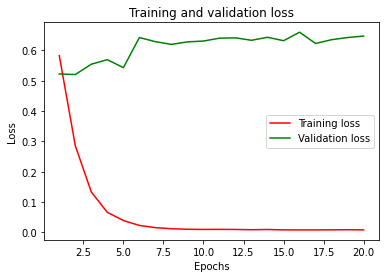

In [28]:
print_loss_history(train_loss, validation_loss)

#### Validation Statistics:

|Model        | Loss  | Accuracy  | Precision | Recall | F1     | 
|-------------|-------|-----------|-----------|--------|--------|
|**Resnet18** | 0.647 | 0.648     | 0.798     | 0.819  | 0.791  |  

In [10]:
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                actual_labels = [disease_labels[idx] for idx, value in enumerate(labels[j]) if value == 1]
                predicted_labels = [disease_labels[idx] for idx, value in enumerate(outputs[j]) if value == 1]
                ax.set_title(f'Actual: {actual_labels}\n Predicted: {predicted_labels}')
                imshow(inputs.cpu().data[j])
                plt.figure(figsize=(10, 10))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

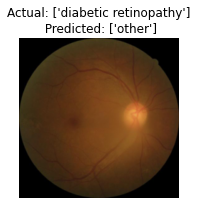

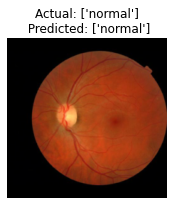

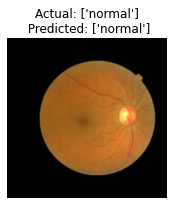

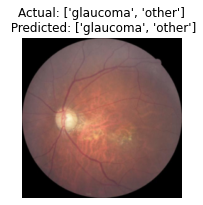

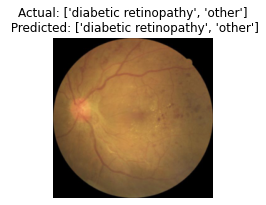

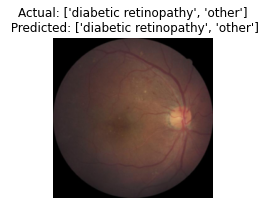

<Figure size 720x720 with 0 Axes>

In [31]:
# print([disease_labels[idx] for idx, value in enumerate(test_array) if value == 1])

# Making some predictions on the test dataset:
visualize_model_predictions(model_ft, num_images=6)

The predictions of the model on the test dataset are very accurate, as evidence in the previous images.

In [32]:
# Function to evaluate the model performance on the test dataset.
def test_model(model):
    model.eval()
    Acc, Prec, Rec, F1 = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in iter(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            
            y_true, y_pred = labels.detach().cpu(), outputs.detach().cpu()

            Acc += accuracy_score(y_true, y_pred)
            Prec += precision_score(y_true, y_pred, average="samples", zero_division=0)
            Rec += recall_score(y_true, y_pred, average="samples", zero_division=0)
            F1 += f1_score(y_true, y_pred, average="samples", zero_division=0)
        
        Acc = Acc / len(dataloaders['test'])
        Prec = Prec / len(dataloaders['test'])
        Rec = Rec / len(dataloaders['test'])
        F1 = F1 / len(dataloaders['test'])
        
    return Acc, Prec, Rec, F1

In [33]:
Acc, Prec, Rec, F1 = test_model(model_ft)
print('Evaluation on the test dataset:')
print('Accuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}'.format(
    Acc, Prec, Rec, F1))

Evaluation on the test dataset:
Accuracy:0.583
Precision:0.775
Recall:0.795
F1:0.763


#### Statistics on the test dataset:

|Model        | Accuracy  | Precision | Recall | F1     | 
|-------------|-----------|-----------|--------|--------|
|**Resnet18** | 0.583     | 0.775     | 0.795  | 0.763  | 

Next, I'll test if training a ResNet50 model would yield better results.

In [37]:
torch.cuda.empty_cache()
model_ft2 = models.resnet50(pretrained=True, progress=True)

# Let's freeze the layers from 1 to 6. Then we would train only the remaining layers.
ct = 0
for child in model_ft2.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(p.numel() for p in model_ft2.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model_ft2.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model_ft2.fc.in_features
model_ft2.fc = nn.Linear(num_ftrs, len(disease_labels))

model_ft2 = model_ft2.to(device)

pos_weight = get_pos_weight(data_df['train'].iloc[:, 1:])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(pos_weight)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft2.parameters()), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft2, train_loss, validation_loss = train_model(model_ft2, criterion, optimizer_ft, exp_lr_scheduler,
                                                    model_name='ResNet50', weights=None,
                                                    num_epochs=epochs)

25,557,032 total number of parameters
24,112,104 parameters to train
tensor([3.7298, 4.6543, 0.4540, 5.4659], device='cuda:0')
Epoch 0/19
----------


86it [00:31,  2.75it/s]                        
17it [00:04,  4.03it/s]                        


TRAIN ==> Loss:0.5376
VAL ==> Loss:0.4842 Acc:0.5067 Prec:0.7031 Rec:0.8094 F1:0.7290
Epoch 1/19
----------


86it [00:31,  2.77it/s]                        
17it [00:04,  3.66it/s]                        


TRAIN ==> Loss:0.2620
VAL ==> Loss:0.4765 Acc:0.6458 Prec:0.7904 Rec:0.8306 F1:0.7934
Epoch 2/19
----------


86it [00:31,  2.74it/s]                        
17it [00:04,  3.88it/s]                        


TRAIN ==> Loss:0.1376
VAL ==> Loss:0.6111 Acc:0.6801 Prec:0.8257 Rec:0.8465 F1:0.8195
Epoch 3/19
----------


86it [00:31,  2.71it/s]                        
17it [00:04,  3.92it/s]                        


TRAIN ==> Loss:0.0888
VAL ==> Loss:0.4976 Acc:0.6654 Prec:0.7907 Rec:0.8208 F1:0.7909
Epoch 4/19
----------


86it [00:31,  2.74it/s]                        
17it [00:04,  3.95it/s]                        


TRAIN ==> Loss:0.0641
VAL ==> Loss:0.6101 Acc:0.6170 Prec:0.7546 Rec:0.7911 F1:0.7560
Epoch 5/19
----------


86it [00:31,  2.72it/s]                        
17it [00:04,  3.71it/s]                        


TRAIN ==> Loss:0.0786
VAL ==> Loss:0.9073 Acc:0.6697 Prec:0.8263 Rec:0.8229 F1:0.8085
Epoch 6/19
----------


86it [00:32,  2.66it/s]                        
17it [00:04,  3.93it/s]                        


TRAIN ==> Loss:0.0588
VAL ==> Loss:0.7011 Acc:0.6201 Prec:0.7767 Rec:0.8842 F1:0.8075
Epoch 7/19
----------


86it [00:32,  2.68it/s]                        
17it [00:04,  3.63it/s]                        


TRAIN ==> Loss:0.0283
VAL ==> Loss:0.4945 Acc:0.6409 Prec:0.8094 Rec:0.8689 F1:0.8179
Epoch 8/19
----------


86it [00:31,  2.73it/s]                        
17it [00:04,  3.60it/s]                        


TRAIN ==> Loss:0.0162
VAL ==> Loss:0.5093 Acc:0.6955 Prec:0.8177 Rec:0.8572 F1:0.8220
Epoch 9/19
----------


86it [00:32,  2.61it/s]                        
17it [00:04,  3.63it/s]                        


TRAIN ==> Loss:0.0135
VAL ==> Loss:0.5155 Acc:0.7059 Prec:0.8336 Rec:0.8759 F1:0.8385
Epoch 10/19
----------


86it [00:31,  2.70it/s]                        
17it [00:04,  3.59it/s]                        


TRAIN ==> Loss:0.0116
VAL ==> Loss:0.5098 Acc:0.6918 Prec:0.8162 Rec:0.8581 F1:0.8213
Epoch 11/19
----------


86it [00:31,  2.75it/s]                        
17it [00:04,  3.79it/s]                        


TRAIN ==> Loss:0.0118
VAL ==> Loss:0.5072 Acc:0.7077 Prec:0.8407 Rec:0.8612 F1:0.8352
Epoch 12/19
----------


86it [00:31,  2.73it/s]                        
17it [00:04,  3.81it/s]                        


TRAIN ==> Loss:0.0084
VAL ==> Loss:0.5319 Acc:0.7169 Prec:0.8480 Rec:0.8612 F1:0.8395
Epoch 13/19
----------


86it [00:31,  2.74it/s]                        
17it [00:04,  3.90it/s]                        


TRAIN ==> Loss:0.0085
VAL ==> Loss:0.5179 Acc:0.6850 Prec:0.8073 Rec:0.8165 F1:0.7981
Epoch 14/19
----------


86it [00:31,  2.72it/s]                        
17it [00:04,  3.89it/s]                        


TRAIN ==> Loss:0.0083
VAL ==> Loss:0.5483 Acc:0.7138 Prec:0.8404 Rec:0.8759 F1:0.8424
Epoch 15/19
----------


86it [00:31,  2.75it/s]                        
17it [00:04,  3.93it/s]                        


TRAIN ==> Loss:0.0083
VAL ==> Loss:0.5218 Acc:0.6955 Prec:0.8355 Rec:0.8523 F1:0.8277
Epoch 16/19
----------


86it [00:31,  2.74it/s]                        
17it [00:04,  3.71it/s]                        


TRAIN ==> Loss:0.0077
VAL ==> Loss:0.4957 Acc:0.6844 Prec:0.8284 Rec:0.8658 F1:0.8292
Epoch 17/19
----------


86it [00:31,  2.69it/s]                        
17it [00:04,  3.95it/s]                        


TRAIN ==> Loss:0.0071
VAL ==> Loss:0.5017 Acc:0.7059 Prec:0.8346 Rec:0.8612 F1:0.8324
Epoch 18/19
----------


86it [00:31,  2.75it/s]                        
17it [00:04,  3.98it/s]                        


TRAIN ==> Loss:0.0069
VAL ==> Loss:0.5015 Acc:0.6991 Prec:0.8346 Rec:0.8634 F1:0.8326
Epoch 19/19
----------


86it [00:31,  2.74it/s]                        
17it [00:04,  3.87it/s]                        

TRAIN ==> Loss:0.0083
VAL ==> Loss:0.4869 Acc:0.7004 Prec:0.8300 Rec:0.8640 F1:0.8308
Training complete in 12m 2s
Best val Loss: 0.476497


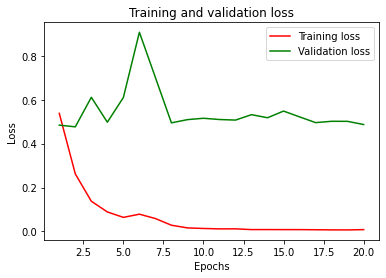

In [38]:
print_loss_history(train_loss, validation_loss)

#### Validation Statistics:

|Model        | Loss  | Accuracy  | Precision | Recall | F1     | 
|-------------|-------|-----------|-----------|--------|--------|
|**Resnet50** | 0.487 | 0.700     | 0.830     | 0.864  | 0.831  |  

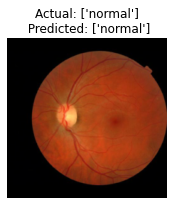

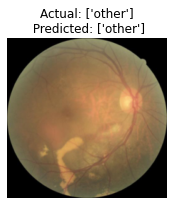

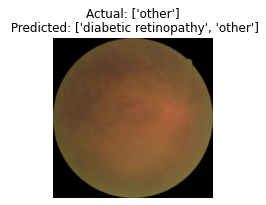

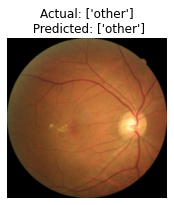

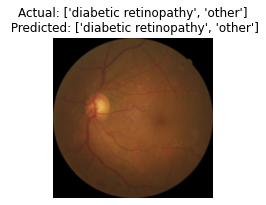

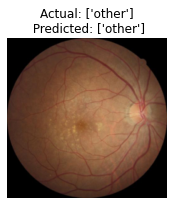

<Figure size 720x720 with 0 Axes>

In [42]:
# Making some predictions on the test dataset:
visualize_model_predictions(model_ft2, num_images=6)

The predictions of the model on the test dataset are very accurate, as evidence in the previous images.

In [43]:
Acc, Prec, Rec, F1 = test_model(model_ft2)
print('Evaluation on the test dataset:')
print('Accuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}'.format(
    Acc, Prec, Rec, F1))

Evaluation on the test dataset:
Accuracy:0.679
Precision:0.834
Recall:0.850
F1:0.826


#### Statistics on the test dataset:

|Model        | Accuracy  | Precision | Recall | F1     | 
|-------------|-----------|-----------|--------|--------|
|**Resnet18** | 0.583     | 0.775     | 0.795  | 0.763  |
|**Resnet50** | 0.679     | 0.834     | 0.850  | 0.826  |

#### According to the statistics the **Resnet50** model performs better.

# 2. Visualizing regions of interest that contribute to the prediction of retinal disorders.

For this task I hand-picked a few images from the test dataset to showcase different retinal disorders. I base my approcah on [this work](https://github.com/jacobgil/pytorch-grad-cam).

In [13]:
# Load the best performing model (Resnet50)
model_ft2 = models.resnet50()
num_ftrs = model_ft2.fc.in_features
model_ft2.fc = nn.Linear(num_ftrs, len(disease_labels))
model_ft2.load_state_dict(torch.load('models/ResNet50.pth'))

<All keys matched successfully>

In [17]:
from PIL import Image
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image

In [35]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.shape[0] + im2.shape[0], im1.shape[1]))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.shape[0], 0))
    return dst

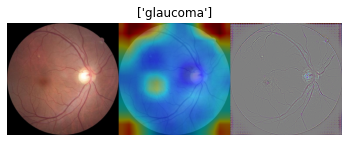

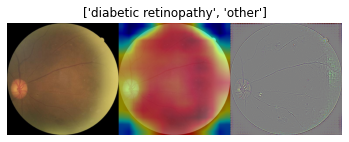

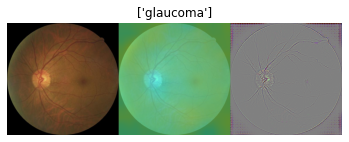

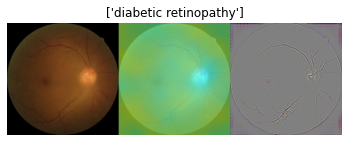

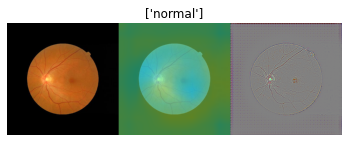

In [62]:
model = model_ft2
target_layers = [model.layer4[-1]]

# Examples images from the test dataset. These where selected manually to showcase different retinal disrders.
example_images = (('data/train/train/30c12f1232bb.jpg', [0, 1, 0, 0]),
                ('data/train/train/0054be0a30b1.jpg', [1, 0, 1, 0]),
                ('data/train/train/50af8887791e.jpg', [0, 1, 0, 0]),
                ('data/train/train/ef8933d65998.jpg', [1, 0, 0, 0]),
                ('data/train/train/4b6f2e8f0a3d.jpg', [0, 0, 0, 1]))

for img_path, label in example_images:
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    target_category = None
    with GradCAM(model=model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:

        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            target_category=target_category,
                            aug_smooth=True,
                            eigen_smooth=True)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, target_category=target_category)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    method = 'GradCAM'
    # cv2.imwrite(f'{method}_cam.jpg', cam_image)
    # cv2.imwrite(f'{method}_gb.jpg', gb)
    # cv2.imwrite(f'{method}_cam_gb.jpg', cam_gb)

    visualization = show_cam_on_image(rgb_img, grayscale_cam)

    ims = np.concatenate((rgb_img,
                          np.float32(visualization)/255,
                          np.float32(gb)/255
                         ), axis=1)

    labels = [disease_labels[idx] for idx, value in enumerate(label) if value == 1]

    plt.title(labels)
    plt.axis("off")
    plt.imshow(ims)
    plt.show()

The images above show the regions of "interest" that cause the model to make a particular prediction. Areas colored in red being important and blue less important. It can be seen in the first image that for that particular case of glaucoma, the model focused on some edges of the retina and on a spot near the center to the left. On the other hand the last three images the focus of the network is not as evident like the first images, but a close look revelas light yellow areas which is where the model focused in these cases to make a prediction. 